In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use is_grad_enabled to determine whether we are in training mode
    if not torch.is_grad_enabled():
        # In prediction mode, use mean and variance obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of X, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
        moving_var = (1.0 - momentum) * moving_var + momentum * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean.data, moving_var.data

In [3]:
class BatchNorm(nn.Module):
    # num_features: the number of outputs for a fully connected layer or the
    # number of output channels for a convolutional layer. num_dims: 2 for a
    # fully connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and
        # 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If X is not on the main memory, copy moving_mean and moving_var to
        # the device where X is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated moving_mean and moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

In [4]:
net = nn.Sequential(
    nn.LazyConv2d(6, kernel_size=5), BatchNorm(6, num_dims=4),
    nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
    nn.LazyConv2d(16, kernel_size=5), BatchNorm(16, num_dims=4),
    nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(), nn.LazyLinear(120),
    BatchNorm(120, num_dims=2), nn.Sigmoid(), nn.LazyLinear(84),
    BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.LazyLinear(10))

C:\ProgramData\Anaconda3\envs\d2l\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [5]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

loss 0.260, train acc 0.904, test acc 0.815
35257.3 examples/sec on cuda:0


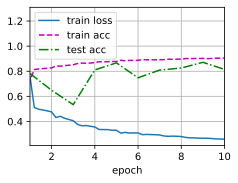

In [6]:
lr, num_epochs = 0.9, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### Implementations using the torch library

In [7]:
net = nn.Sequential(
    nn.LazyConv2d(6, kernel_size=5), nn.LazyBatchNorm2d(),
    nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
    nn.LazyConv2d(16, kernel_size=5), nn.LazyBatchNorm2d(),
    nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(), nn.LazyLinear(120), nn.LazyBatchNorm1d(),
    nn.Sigmoid(), nn.LazyLinear(84), nn.LazyBatchNorm1d(),
    nn.Sigmoid(), nn.LazyLinear(10))

loss 0.269, train acc 0.902, test acc 0.879
59446.9 examples/sec on cuda:0


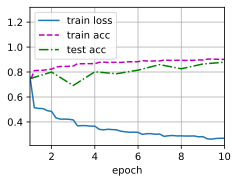

In [8]:
lr, num_epochs = 0.9, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())